# Day 1, Lecture 2

**Topic: dynamics**

In [31]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Iterating over a trajectory

In [6]:
import MDAnalysis as mda
import nglview as nv
from MDAnalysis.tests.datafiles import PSF, DCD

As in the earlier session, we can use NGLView to traverse through the trajectory visually.

In [7]:
closed_to_open = mda.Universe(PSF, DCD)
nv.show_mdanalysis(closed_to_open)

NGLWidget(max_frame=97)

### Working with AtomGroups: FRET distances

Experimental FRET labels: distances

<div>
<img src="figures/fret_distances_adk.png" alt="FRET distances" width="250"/>
</div>


* I52 - K145
* A55 - V169
* A127 - A194

Calculate the C$_\beta$ distances as proxies for the spin-label distances.

Sampling large conformational is challenging with standard equilibrium MD. Therefore we used an enhanced sampling method ("dynamic importance sampling", DIMS) to generate transitions between closed and open apo AdK [2, 3] in addition to "brute force" equilibrium MD (on PSC Anton).


In [8]:
beta = closed_to_open.select_atoms("name CB")

donors = beta.select_atoms("resname ILE and resid 52", 
                           "resname ALA and resid 55",
                           "resname ALA and resid 127")
acceptors = beta.select_atoms("resname LYS and resid 145", 
                           "resname VAL and resid 169",
                           "resname ALA and resid 194")

Indexing the trajectory sets the active frame to that index.

In [13]:
closed_to_open.trajectory[0]
print(f"Frame: {closed_to_open.trajectory.frame}")
print(f"Time: {closed_to_open.trajectory.time}")

Frame: 0
Time: 0.9999999119200186


In [14]:
closed_to_open.trajectory[-1]
print(f"Frame: {closed_to_open.trajectory.frame}")
print(f"Time: {closed_to_open.trajectory.time}")

Frame: 97
Time: 97.99999136816182


Setting the frame updates dynamic data such as positions. Note that the positions array itself does not update.

In [16]:
closed_to_open.trajectory[0]
print(closed_to_open.trajectory.frame)
donor_positions = donors.positions
donor_positions

0


array([[ -2.3910754, -16.362959 ,   3.6749218],
       [ -7.6395893, -16.166595 ,   7.512685 ],
       [-13.415007 ,  -5.2870574,  -8.834947 ]], dtype=float32)

In [17]:
closed_to_open.trajectory[-1]
print(closed_to_open.trajectory.frame)
donor_positions

97


array([[ -2.3910754, -16.362959 ,   3.6749218],
       [ -7.6395893, -16.166595 ,   7.512685 ],
       [-13.415007 ,  -5.2870574,  -8.834947 ]], dtype=float32)

Rather, it's the AtomGroup that updates.

In [18]:
donors.positions

array([[  4.171742  , -22.14687   ,  -2.0800915 ],
       [  0.22647852, -27.779528  ,  -2.4970996 ],
       [-25.531727  ,  -5.927316  ,  -3.3390718 ]], dtype=float32)

The more common way to traverse through a trajectory (e.g. for analysis) is to iterate through it.

In [19]:
for ts in closed_to_open.trajectory:
    print(f"Frame: {ts.frame}, time: {ts.time}")

Frame: 0, time: 0.9999999119200186
Frame: 1, time: 1.9999998238400372
Frame: 2, time: 2.999999735760056
Frame: 3, time: 3.9999996476800743
Frame: 4, time: 4.999999559600093
Frame: 5, time: 5.999999471520112
Frame: 6, time: 6.99999938344013
Frame: 7, time: 7.999999295360149
Frame: 8, time: 8.999999207280167
Frame: 9, time: 9.999999119200186
Frame: 10, time: 10.999999031120204
Frame: 11, time: 11.999998943040223
Frame: 12, time: 12.999998854960241
Frame: 13, time: 13.99999876688026
Frame: 14, time: 14.999998678800278
Frame: 15, time: 15.999998590720297
Frame: 16, time: 16.999998502640317
Frame: 17, time: 17.999998414560334
Frame: 18, time: 18.999998326480352
Frame: 19, time: 19.999998238400373
Frame: 20, time: 20.99999815032039
Frame: 21, time: 21.999998062240408
Frame: 22, time: 22.999997974160426
Frame: 23, time: 23.999997886080447
Frame: 24, time: 24.999997798000464
Frame: 25, time: 25.999997709920482
Frame: 26, time: 26.999997621840503
Frame: 27, time: 27.99999753376052
Frame: 28, ti

You can also easily slice the trajectory.

In [23]:
for ts in closed_to_open.trajectory[2:92:8]:
    print(f"Frame: {ts.frame}, time: {ts.time}")

Frame: 2, time: 2.999999735760056
Frame: 10, time: 10.999999031120204
Frame: 18, time: 18.999998326480352
Frame: 26, time: 26.999997621840503
Frame: 34, time: 34.99999691720065
Frame: 42, time: 42.9999962125608
Frame: 50, time: 50.99999550792095
Frame: 58, time: 58.9999948032811
Frame: 66, time: 66.99999409864124
Frame: 74, time: 74.9999933940014
Frame: 82, time: 82.99999268936155
Frame: 90, time: 90.99999198472169


Let's apply this to the FRET analysis we did earlier. First, for convenience, let's codify the analysis into a function. The arguments (`donors`, `acceptors`) are `AtomGroup`s so that we can work the the updated positions arrays for each frame.

In [26]:
def calculate_fret_distances(donors, acceptors):
    return np.linalg.norm(donors.positions - acceptors.positions, axis=1)

In [28]:
distances = []
times = []
for ts in closed_to_open.trajectory:
    d = calculate_fret_distances(donors, acceptors)
    distances.append(d)
    times.append(ts.time)
print(distances[:3])

[[31.091139 12.611019 31.881138]
 [31.45864  12.313753 32.208305]
 [31.784407 12.565103 32.187794]]


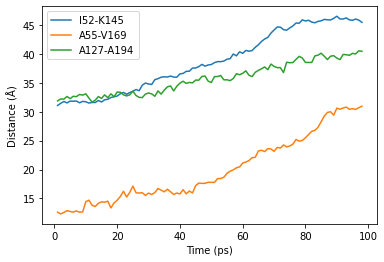

In [33]:
import matplotlib.pyplot as plt

plt.plot(times, distances)
plt.legend(("I52-K145", "A55-V169", "A127-A194"))
plt.xlabel("Time (ps)")
plt.ylabel(r"Distance (Å)");

### Working with UpdatingAtomGroups: solvent shells

In [34]:
from MDAnalysisData import datasets
ifabp_data = datasets.fetch_ifabp_water()
ifabp = mda.Universe(ifabp_data.topology, ifabp_data.trajectory)

ifabp_water.psf: 2.19MB [00:00, 5.62MB/s]                            
ifabp_water_0.pdb: 958kB [00:00, 2.71MB/s]                            
rmsfit_ifabp_water_1.dcd: 74.7MB [00:01, 70.2MB/s]                            


In [36]:
solvshell_static = ifabp.select_atoms("resname TIP3 and around 5.0 protein")
solvshell_static

<AtomGroup with 3868 atoms>

In [37]:
ifabp.trajectory[-1]
solvshell_static

<AtomGroup with 3868 atoms>

In [38]:
solvshell_updating = ifabp.select_atoms("resname TIP3 and around 5.0 protein", updating=True)
solvshell_updating

<AtomGroup with 2889 atoms, with selection 'resname TIP3 and around 5.0 protein' on the entire Universe.>

In [39]:
ifabp.trajectory[0]
solvshell_updating

<AtomGroup with 3868 atoms, with selection 'resname TIP3 and around 5.0 protein' on the entire Universe.>

In [40]:
times = []
n_waters = []
for ts in ifabp.trajectory:
    times.append(ts.time)
    n_waters.append(len(solvshell_updating.residues))
print(n_waters[:3])

[1449, 1458, 1482]


# uhhh why are the times negative

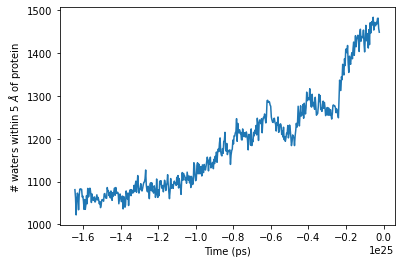

In [43]:
plt.plot(times, n_waters)
plt.xlabel("Time (ps)")
plt.ylabel(r"# waters within 5 $\AA$ of protein");